<a href="https://colab.research.google.com/github/SuperCoolCucumber/CompLing/blob/main/Finetuning_homework9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).




In [2]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from transformers import AutoModel
from transformers import AutoTokenizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [5]:
data.topic.value_counts()

Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

## Model 1: [ruRoberta-large](https://huggingface.co/sberbank-ai/ruRoberta-large)

In [6]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [7]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large")

model_sber = AutoModelForMaskedLM.from_pretrained("sberbank-ai/ruRoberta-large").to(torch.device('cuda'))

In [8]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):
        
        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)
        
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [9]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)

In [10]:
MAX_LEN = 512

In [11]:
texts = data.title.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [12]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [13]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [14]:
import torch.nn as nn

class CLF(nn.Module):
    
    def __init__(self, pretrained_model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer 
        self.pretrained_model = pretrained_model 
        
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(50265, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)
        
        return outputs

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_sber, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-6)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [16]:
f1s = []
f1s_eval = []

for i in range(20):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.03125
1
Eval -  0.06458333333333333
2
Eval -  0.22083333333333333
3
Eval -  0.38541666666666663
4
Eval -  0.28750000000000003
5
Eval -  0.35625000000000007
6
Eval -  0.35625000000000007
7
Eval -  0.32500000000000007
8
Eval -  0.31666666666666665
9
Eval -  0.32500000000000007
10
Eval -  0.3208333333333333
11
Eval -  0.35625000000000007
12
Eval -  0.3208333333333333
13
Eval -  0.32708333333333334
14
Eval -  0.32500000000000007
15
Eval -  0.36041666666666666
16
Eval -  0.3520833333333333
17
Eval -  0.35416666666666663
18
Eval -  0.38541666666666663
19
Eval -  0.3520833333333333


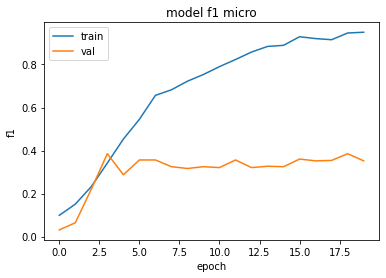

In [17]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model 2: [LaBSE for English and Russian](https://huggingface.co/cointegrated/LaBSE-en-ru)

In [18]:
from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")

model_labse = AutoModelForPreTraining.from_pretrained("cointegrated/LaBSE-en-ru")

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

In [19]:
import torch.nn as nn

class CLF(nn.Module):
    
    def __init__(self, pretrained_model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer
        self.pretrained_model = pretrained_model 
        #
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(55083, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)
        
        return outputs

In [20]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_labse, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-6)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [22]:
f1s = []
f1s_eval = []

for i in range(20):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.03333333333333333
1
Eval -  0.03333333333333333
2
Eval -  0.16458333333333333
3
Eval -  0.19166666666666665
4
Eval -  0.22500000000000003
5
Eval -  0.19375000000000003
6
Eval -  0.22708333333333333
7
Eval -  0.22500000000000003
8
Eval -  0.22500000000000003
9
Eval -  0.29375000000000007
10
Eval -  0.25625000000000003
11
Eval -  0.2895833333333333
12
Eval -  0.32291666666666663
13
Eval -  0.32291666666666663
14
Eval -  0.29166666666666663
15
Eval -  0.3208333333333333
16
Eval -  0.3520833333333333
17
Eval -  0.38958333333333334
18
Eval -  0.32708333333333334
19
Eval -  0.2895833333333333


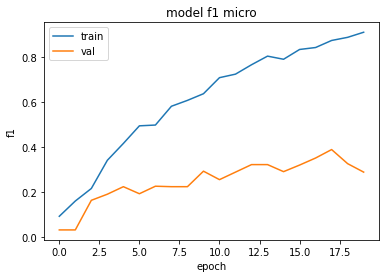

In [23]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model 3: [rubert-tiny2](https://huggingface.co/cointegrated/rubert-tiny2)

In [24]:
from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

model_rubert = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny2")

Downloading:   0%|          | 0.00/401 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/715 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112M [00:00<?, ?B/s]

In [25]:
class CLF(nn.Module):
    
    def __init__(self, pretrained_model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer 
        self.pretrained_model = pretrained_model 
        
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(83828, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)
        
        return outputs

In [26]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_rubert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-6)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [28]:
f1s = []
f1s_eval = []

for i in range(20):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.09583333333333333
1
Eval -  0.16250000000000003
2
Eval -  0.28750000000000003
3
Eval -  0.3208333333333333
4
Eval -  0.26041666666666663
5
Eval -  0.28750000000000003
6
Eval -  0.35625000000000007
7
Eval -  0.26041666666666663
8
Eval -  0.32291666666666663
9
Eval -  0.32500000000000007
10
Eval -  0.35416666666666663
11
Eval -  0.29166666666666663
12
Eval -  0.31875000000000003
13
Eval -  0.35416666666666663
14
Eval -  0.35416666666666663
15
Eval -  0.35625000000000007
16
Eval -  0.32291666666666663
17
Eval -  0.35625000000000007
18
Eval -  0.35416666666666663
19
Eval -  0.2895833333333333


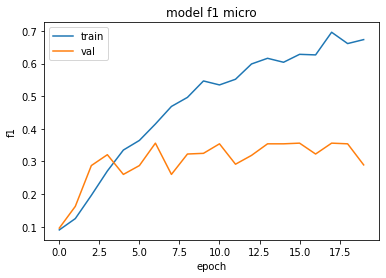

In [29]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Все три модели показали довольно низкий f1 score, поднимался примерно до уровня 0.3. Вероятно, это связано с небольшим объемом обучающей выборки. Все модели обучились очень быстро.

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

2) Чем модель T5 отличается от ROBERTA/BERT? 

RoBERTa -- это конфигурация модели BERT, которая была описана в статье [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692). Это тот же BERT, но
1) ROBERTA обучали дольше, на большем количестве данных (16 гб-160 гб) и с более крупными батчами;
2) в ROBERTA нет предсказания следующего предложения (NSP, то есть показатель, определяющий, когда модель предсказала, из одного ли источника взять две последовательности, которые ей показывают);
3) ее обучали на более длинных последовательностях;
4) в процессе обучения динамически менялся маскинг тренировочных данных.


Модель T5, или Text-to-Text Transfer Transformer, была обучена на большом корпусе С4 (Colossal Clean Crawled Corpus). Архитетура Т5 построена как encoder-decoder, то есть модель на выходе отдает текстовую строку. В отличие от Т5, у BERT -- это только encoder, который выдет лейбл, например

